In [3]:
import csv
import jieba
import numpy as np

import xlrd

In [4]:
#打开词典文件，返回列表
def open_dict(Dict, path):
    path = path + '%s.txt' % Dict
    dictionary = open(path, 'r', encoding='utf-8')
    dict = []
    for word in dictionary:
        word = word.strip('\n')
        dict.append(word)
    return dict

In [5]:
def judgeodd(num):
    if (num % 2) == 0:
        return 'even'
    else:
        return 'odd'

In [6]:
#修改成自己的path路径。
deny_word = open_dict(Dict = '否定词', path= r'./')
posdict = open_dict(Dict = 'positive', path= r'./')
negdict = open_dict(Dict = 'negative', path= r'./')
degree_word = open_dict(Dict = '程度级别词语', path= r'./')
mostdict = degree_word[degree_word.index('extreme')+1 : degree_word.index('very')]#权重4，即在情感词前乘以3
verydict = degree_word[degree_word.index('very')+1 : degree_word.index('more')]#权重3
moredict = degree_word[degree_word.index('more')+1 : degree_word.index('ish')]#权重2
ishdict = degree_word[degree_word.index('ish')+1 : degree_word.index('last')]#权重0.5

In [7]:
def sentiment_score_list(dataset):
    seg_sentence = dataset.split('。')

    count1 = []
    count2 = []
    for sen in seg_sentence: #循环遍历每一个评论
        segtmp = jieba.lcut(sen, cut_all=False)  #把句子进行分词，以列表的形式返回
        i = 0 #记录扫描到的词的位置
        a = 0 #记录情感词的位置
        poscount = 0 #积极词的第一次分值
        poscount2 = 0 #积极词反转后的分值
        poscount3 = 0 #积极词的最后分值（包括叹号的分值）
        negcount = 0
        negcount2 = 0
        negcount3 = 0
        for word in segtmp:
            if word in posdict:  # 判断词语是否是情感词
                poscount += 1
                c = 0
                for w in segtmp[a:i]:  # 扫描情感词前的程度词
                    if w in mostdict:
                        poscount *= 4.0
                    elif w in verydict:
                        poscount *= 3.0
                    elif w in moredict:
                        poscount *= 2.0
                    elif w in ishdict:
                        poscount *= 0.5
                    elif w in deny_word:
                        c += 1
                if judgeodd(c) == 'odd':  # 扫描情感词前的否定词数
                    poscount *= -1.0
                    poscount2 += poscount
                    poscount = 0
                    poscount3 = poscount + poscount2 + poscount3
                    poscount2 = 0
                else:
                    poscount3 = poscount + poscount2 + poscount3
                    poscount = 0
                a = i + 1  # 情感词的位置变化

            elif word in negdict:  # 消极情感的分析，与上面一致
                negcount += 1
                d = 0
                for w in segtmp[a:i]:
                    if w in mostdict:
                        negcount *= 4.0
                    elif w in verydict:
                        negcount *= 3.0
                    elif w in moredict:
                        negcount *= 2.0
                    elif w in ishdict:
                        negcount *= 0.5
                    elif w in degree_word:
                        d += 1
                if judgeodd(d) == 'odd':
                    negcount *= -1.0
                    negcount2 += negcount
                    negcount = 0
                    negcount3 = negcount + negcount2 + negcount3
                    negcount2 = 0
                else:
                    negcount3 = negcount + negcount2 + negcount3
                    negcount = 0
                a = i + 1
            elif word == '！' or word == '!':  ##判断句子是否有感叹号
                for w2 in segtmp[::-1]:  # 扫描感叹号前的情感词，发现后权值+2，然后退出循环
                    if w2 in posdict or negdict:
                        poscount3 += 2
                        negcount3 += 2
                        break
            i += 1 # 扫描词位置前移


            # 防止出现负数的情况
            pos_count = 0
            neg_count = 0
            if poscount3 < 0 and negcount3 > 0:
                neg_count += negcount3 - poscount3
                pos_count = 0
            elif negcount3 < 0 and poscount3 > 0:
                pos_count = poscount3 - negcount3
                neg_count = 0
            elif poscount3 < 0 and negcount3 < 0:
                neg_count = -poscount3
                pos_count = -negcount3
            else:
                pos_count = poscount3
                neg_count = negcount3

            count1.append([pos_count, neg_count])
        count2.append(count1)
        count1 = []

    return count2

In [8]:
def sentiment_score(senti_score_list):
    score = []
    for review in senti_score_list:
        score_array = np.matrix(review)
        Pos = np.sum(score_array,axis=0)
        Neg = np.sum(score_array[:, 1])
        score.append([Pos, Neg])
    return score

In [9]:
result = []
i=0

In [10]:
with open("孟晚舟回国与祖国强大.txt","r",encoding = "utf_8") as f:
    while 1:
        line = f.readline()
        if not line:
            break
        result.append(sentiment_score(sentiment_score_list(line)))
        i+=1

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\HELLOZ~1\AppData\Local\Temp\jieba.cache
Loading model cost 1.052 seconds.
Prefix dict has been built successfully.


In [11]:
result

[[[matrix([[642,  56]]), 56],
  [matrix([[615,   0]]), 0],
  [matrix([[784,  14]]), 14],
  [matrix([[260,   0]]), 0],
  [matrix([[1673,   10]]), 10],
  [matrix([[572,   0]]), 0],
  [matrix([[786,  62]]), 62],
  [matrix([[6606.,  202.]]), 202.0],
  [matrix([[477,   0]]), 0],
  [matrix([[4649.,  264.]]), 264.0],
  [matrix([[100,   0]]), 0],
  [matrix([[434,   0]]), 0],
  [matrix([[1283,   80]]), 80],
  [matrix([[1156,  128]]), 128],
  [matrix([[828.,  93.]]), 93.0],
  [matrix([[4165,  194]]), 194],
  [matrix([[373,  22]]), 22],
  [matrix([[225,  40]]), 40],
  [matrix([[257,   0]]), 0],
  [matrix([[2077,    0]]), 0],
  [matrix([[1172,   24]]), 24],
  [matrix([[838,  50]]), 50],
  [matrix([[4735.,  302.]]), 302.0],
  [matrix([[2549,  100]]), 100],
  [matrix([[1444,    0]]), 0],
  [matrix([[9678,  816]]), 816],
  [matrix([[102.,   0.]]), 0.0],
  [matrix([[2696,    0]]), 0],
  [matrix([[1056,    0]]), 0],
  [matrix([[961,  60]]), 60],
  [matrix([[86.,  2.]]), 2.0],
  [matrix([[205,   0]]), 0

In [13]:
result = result[0]

result[2][0][0,0]

In [14]:
len(result)

2853

len(result)

type(result[1][0][0,0])

In [29]:
positive = 0
negative = 0

In [30]:
i =0

In [17]:
##情感分析总和
while i <len(result):
    positive +=result[i][0][0,0]
    negative +=result[i][0][0,1]
    i += 1

In [31]:
##每一个评论的情感分析
while i <len(result):
    if result[i][0][0,0] > result[i][0][0,1]:
        positive +=1
    else :
        negative +=1 
    i+=1

In [32]:
positive

2853

In [33]:
negative

0

In [20]:
# -*- coding: utf-8 -*-
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
font = FontProperties(fname=r"C:\Windows\Fonts\simhei.ttf", size=14)  

<ipython-input-34-b70977171444>:15: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.title(u'孟晚舟回国知乎问答情感分析', FontProperties=font)


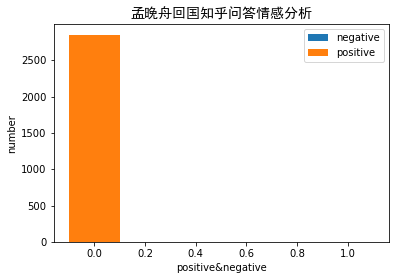

In [34]:
plt.bar([1], [negative], label='negative',width = 0.2)
plt.bar([0], [positive], label='positive',width = 0.2)

# x: 条形图x轴
# y：条形图的高度
# width：条形图的宽度 默认是0.8
# bottom：条形底部的y坐标值 默认是0
# align：center / edge 条形图是否以x轴坐标为中心点或者是以x轴坐标为边缘

plt.legend()

plt.xlabel('positive&negative')
plt.ylabel('number')

plt.title(u'孟晚舟回国知乎问答情感分析', FontProperties=font)

plt.show()


In [ ]:
# 1、直方图
fig = plt.figure()
ax = fig.add_subplot(111)
ax.hist([positive,negative], bins=7)
plt.title('feeling')
plt.xlabel('p&n')
plt.ylabel('value')
plt.show()


In [ ]:
data = '你就是个王八蛋，混账玩意!你们的手机真不好用！非常生气，我非常郁闷！！！！'
data2= '我好开心啊，非常非常非常高兴！今天我得了一百分，我很兴奋开心，愉快，开心'

print(sentiment_score(sentiment_score_list(data)))
print(sentiment_score(sentiment_score_list(data2)))

In [ ]:
from textblob.classifiers import NaiveBayesClassifier

train=[
        ('I love this car','pos'),
        ('This view is amazing','pos'),
        ('I feel great','pos'),
        ('I am so excited about the concert','pos'),
        ("He is my best friend",'pos'),
        ('I do not like this car','neg'),
        ('This view is horrible','neg'),
        ("I feel tired this morning",'neg'),
        ('I am not looking forward to the concert','neg'),
        ('He is an annoying enemy','neg')
]

test=[
        ('I feel happy this morning','pos'),
        ('Oh I love my friend','pos'),
        ('not like that man','neg'),
        ("this hourse is not great",'neg'),
        ('your song is annoying','neg')
]

cl=NaiveBayesClassifier(train)

for sentence in test:
    print(sentence[0],'：',cl.classify(sentence[0]))